In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
# from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import all datasets
train = pd.read_csv("aug_train.csv")
test = pd.read_csv("aug_test.csv")

In [3]:
# Understand business problem

# The company wants to try to predict which of these candidates are really wants to work for the company after training
# This allows the company to have better insight whether to arrange better quality training for those who willing to work for them
# This may help to filter out qualified candidates.
# Thus save some time and cost for HR. 

In [4]:
# Features Description

# enrollee_id : Unique ID for candidate
# city: City code
# city_ development _index : Developement index of the city (scaled)
# gender: Gender of candidate
# relevent_experience: Relevant experience of candidate
# enrolled_university: Type of University course enrolled if any
# education_level: Education level of candidate
# major_discipline :Education major discipline of candidate
# experience: Candidate total experience in years
# company_size: No of employees in current employer's company
# company_type : Type of current employer
# last_new_job: Difference in years between previous job and current job
# training_hours: training hours completed
# target: 0 – Not looking for job change, 1 – Looking for a job change

In [5]:
# check the first 5 rows of df
train.head()

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

In [6]:
# drop both columns "enrollee_id" and "city"
train.drop(["enrollee_id", "city"], axis=1, inplace=True)
test.drop(["enrollee_id", "city"], axis=1, inplace=True)

In [7]:
# have a summary for numerical features
train.describe()

city_development_index  training_hours        target
count            19158.000000    19158.000000  19158.000000
mean                 0.828848       65.366896      0.249348
std                  0.123362       60.058462      0.432647
min                  0.448000        1.000000      0.000000
25%                  0.740000       23.000000      0.000000
50%                  0.903000       47.000000      0.000000
75%                  0.920000       88.000000      0.000000
max                  0.949000      336.000000      1.000000

In [8]:
# change column "target" from float to int
train["target"] = train["target"].apply(int)

## Exploratory Data Analysis

In [9]:
# check for missing values
# it seems train has some missing values 
train.isnull().mean()

city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [10]:
# check for missing values
# it seems test has some missing values 
test.isnull().mean()

city_development_index    0.000000
gender                    0.238610
relevent_experience       0.000000
enrolled_university       0.014561
education_level           0.024425
major_discipline          0.146548
experience                0.002349
company_size              0.292156
company_type              0.297792
last_new_job              0.018788
training_hours            0.000000
dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

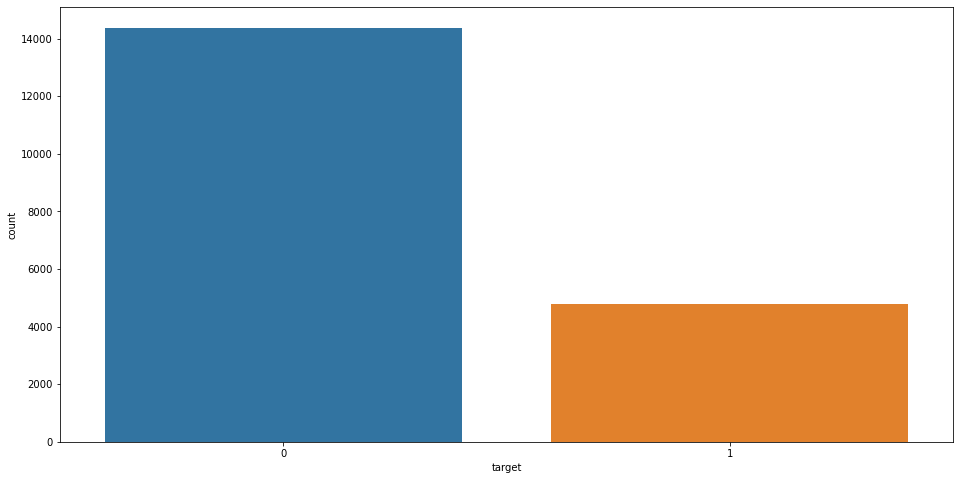

In [11]:
# check the target
# it seems we have class imbalance
# there are more not looking for job change than ones looking for a job change

plt.figure(figsize=(16,8))
sns.countplot(train["target"])

<AxesSubplot:xlabel='training_hours', ylabel='city_development_index'>

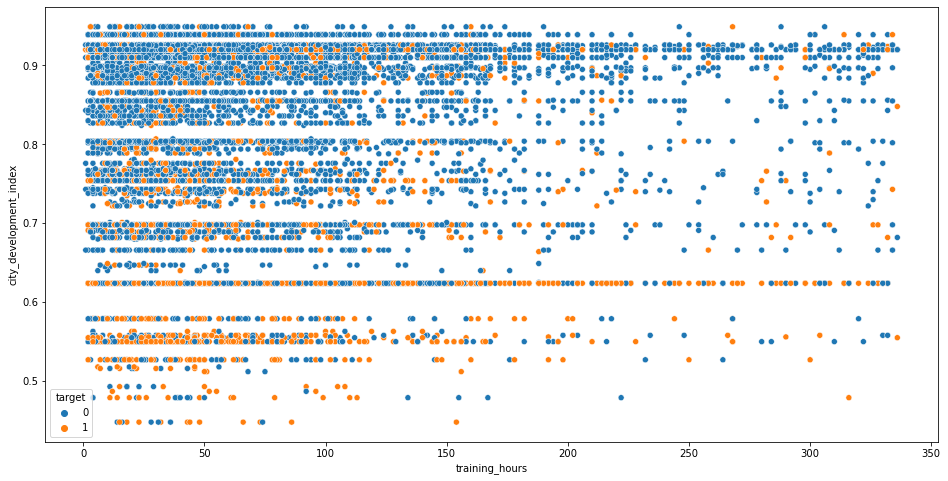

In [12]:
# check the separability of target classes
# it may notice that class 0 (Not looking for job change) are mostly located at higher city_development_index

plt.figure(figsize=(16,8))
sns.scatterplot(data=train, x="training_hours", y="city_development_index", hue="target")

<Figure size 1152x576 with 0 Axes>

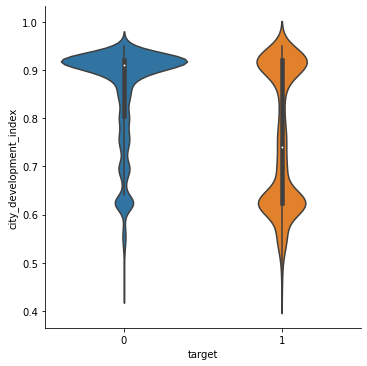

In [13]:
# check whether "city_development_index" does have any effect on "target"
# at higher "city_development_index", there are higher number of "target" 0, indicating more not looking for job change

plt.figure(figsize=(16,8))
sns.catplot(kind="violin", data=train, y="city_development_index", x="target")

<AxesSubplot:xlabel='gender', ylabel='count'>

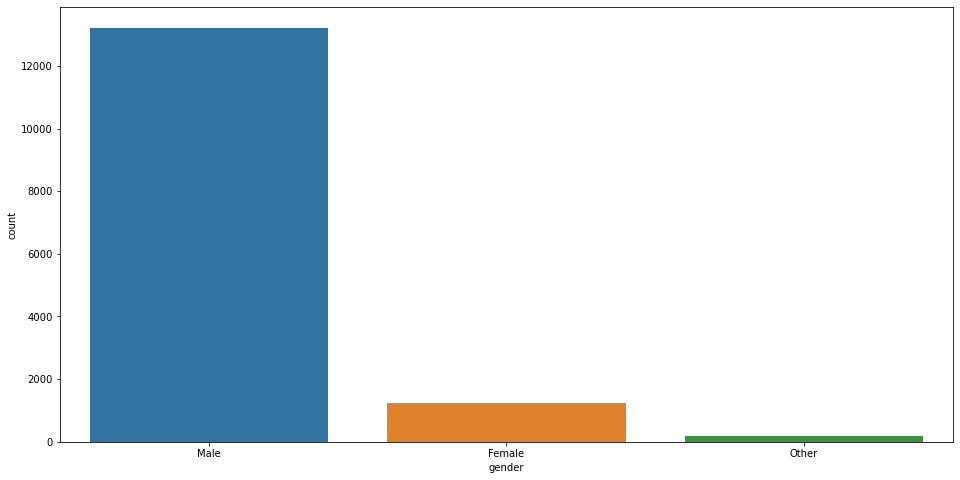

In [14]:
# check the column "Gender"
# it seems like there are a lot more male candidates
# perhaps males are more interested in becoming a data scientist

plt.figure(figsize=(16,8))
sns.countplot(data=train, x="gender")

<AxesSubplot:xlabel='relevent_experience', ylabel='count'>

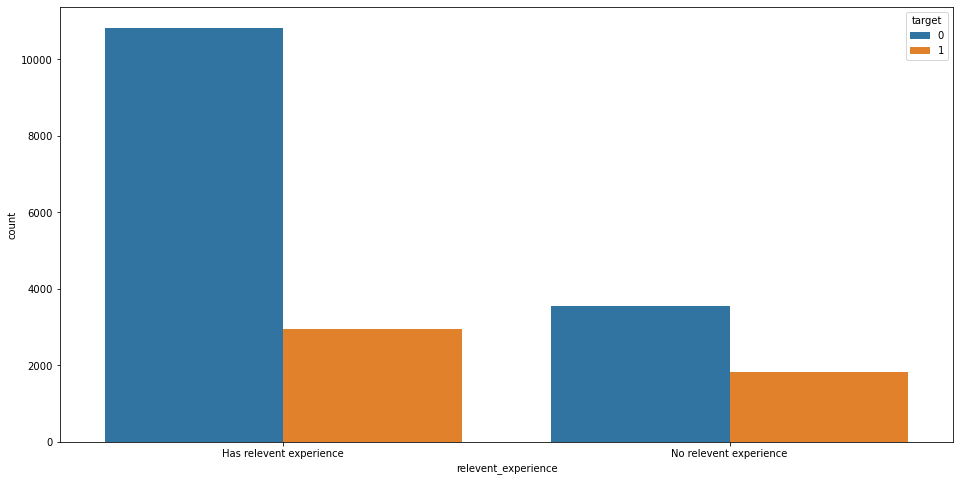

In [15]:
# check the column "relevent_experience" 

plt.figure(figsize=(16,8))
sns.countplot(data=train, x="relevent_experience", hue="target")

<AxesSubplot:xlabel='enrolled_university', ylabel='target'>

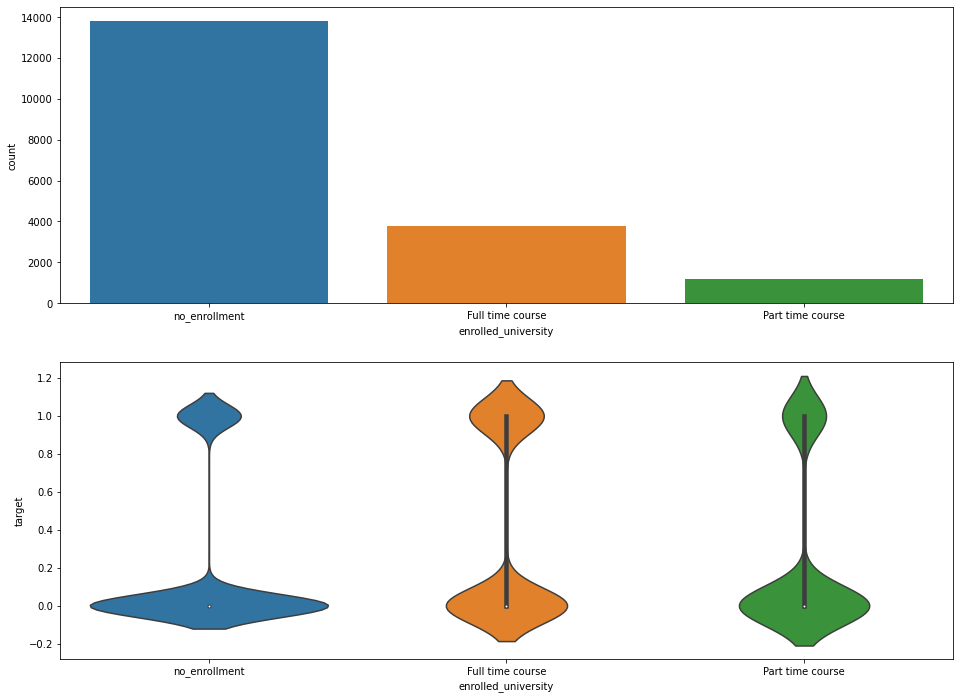

In [16]:
# check the column "enrolled_university" 
# there are higher number of "no_enrollment" 
# it seems candidates with no university enrollment were likely not looking for a job change

plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.countplot(data=train, x="enrolled_university")

plt.subplot(2,1,2)
sns.violinplot(x='enrolled_university', y='target', data=train)

<AxesSubplot:xlabel='education_level', ylabel='target'>

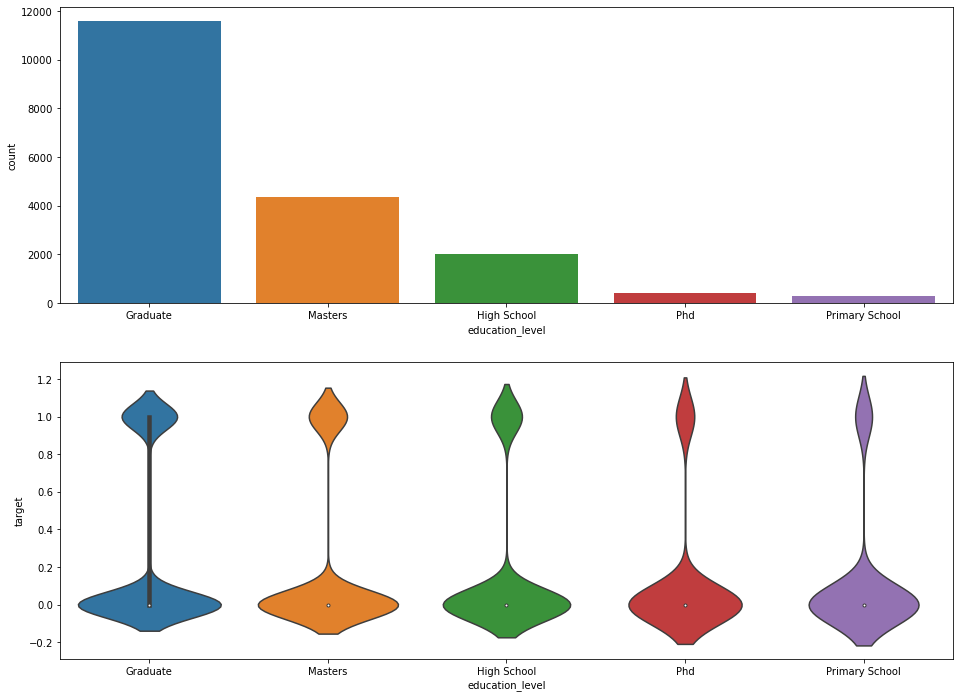

In [17]:
# check the column "education_level" 
# there are higher number of "Graduate" 
# it seems candidates with "Primary School" and "Phd" were likely not looking for a job change

plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.countplot(data=train, x="education_level")

plt.subplot(2,1,2)
sns.violinplot(x='education_level', y='target', data=train)

<AxesSubplot:xlabel='major_discipline', ylabel='target'>

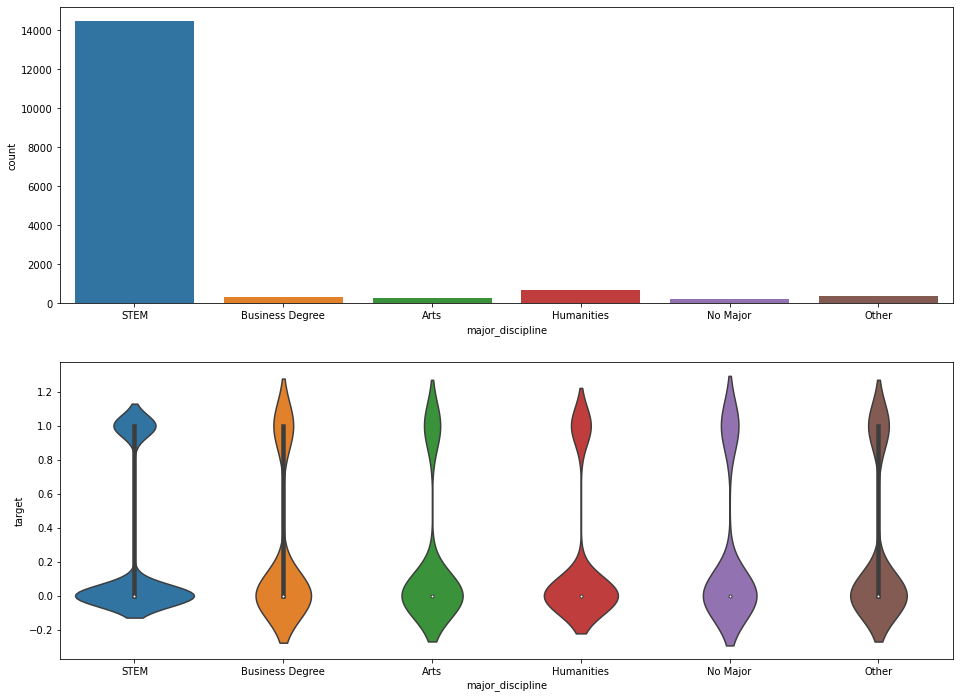

In [18]:
# check the column "major_discipline" 
# there are higher number of "STEM" 
# it may seems candidates with "STEM" were not looking for job change, but, it was inaccurate to say such since "STEM" 
# has very large number

plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.countplot(data=train, x="major_discipline")

plt.subplot(2,1,2)
sns.violinplot(x='major_discipline', y='target', data=train)

<AxesSubplot:xlabel='experience', ylabel='count'>

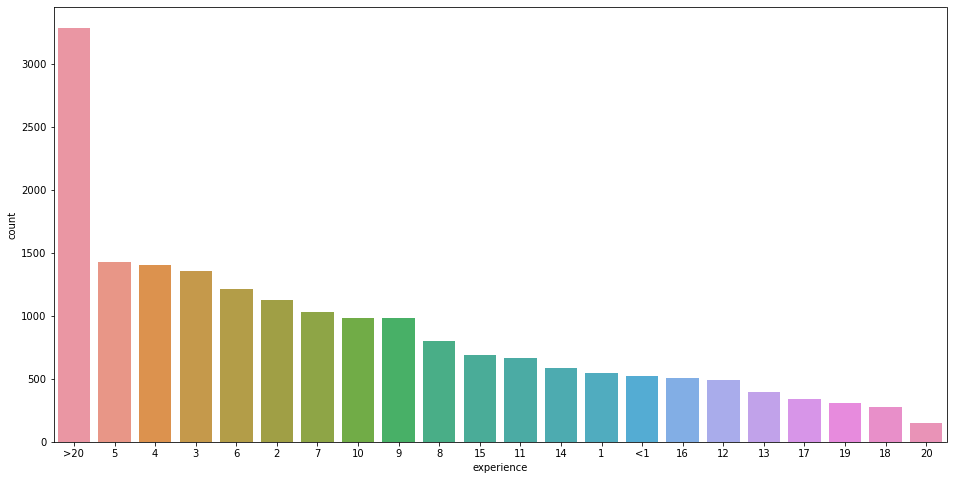

In [19]:
# check the column "experience"

plt.figure(figsize=(16,8))
sns.countplot(data=train, x="experience", order=train["experience"].value_counts(ascending=False).index)

<AxesSubplot:xlabel='company_size', ylabel='count'>

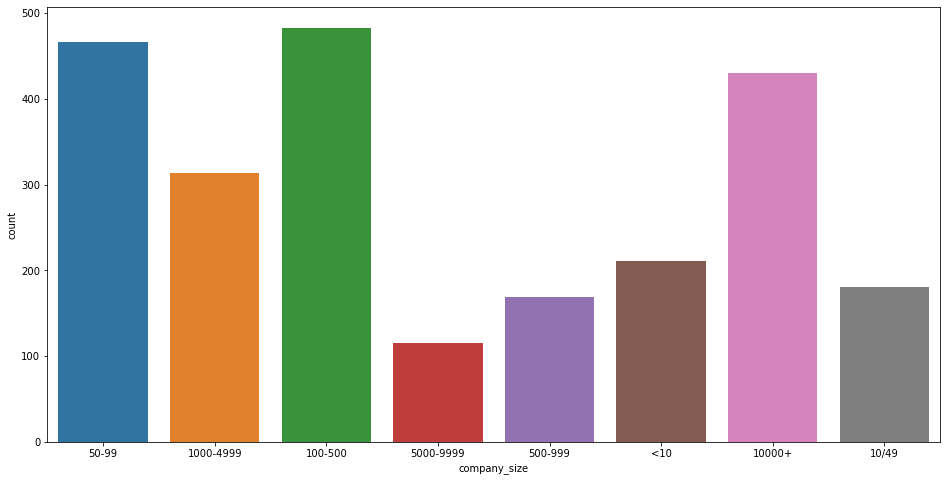

In [20]:
# check "company_size" for those candidates with experience more than 20 years
# strangely, those with experience more than 20 years were prefer to work at smaller companies

plt.figure(figsize=(16,8))
sns.countplot(data=train[train["experience"] == ">20"], x="company_size")

<AxesSubplot:xlabel='company_size', ylabel='count'>

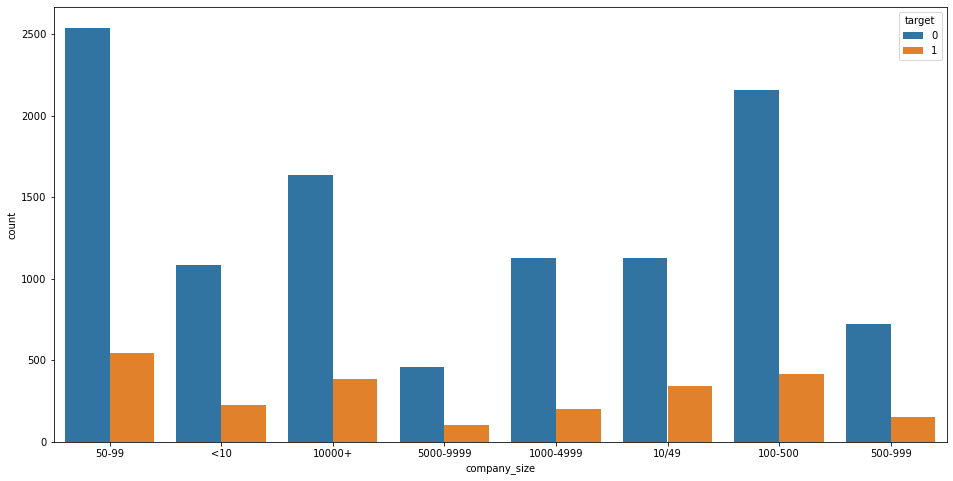

In [21]:
# check the column "company_size" 
# there are always more candidates not looking for a job change at every company_size

plt.figure(figsize=(16,8))
sns.countplot(data=train, x="company_size", hue="target")

<AxesSubplot:xlabel='company_type', ylabel='count'>

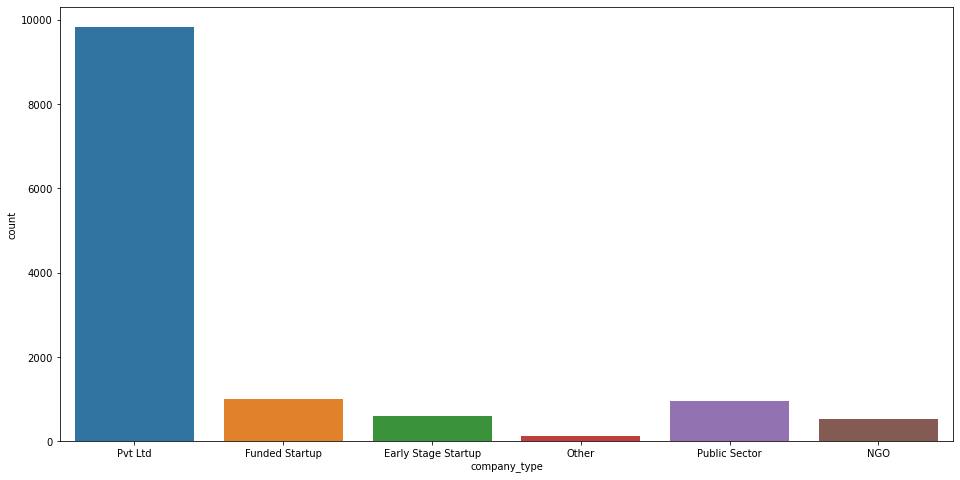

In [22]:
# check the column "company_type" 
# there were more candidates from "Pvt Ltd" 

plt.figure(figsize=(16,8))
sns.countplot(data=train, x="company_type")

<AxesSubplot:xlabel='last_new_job', ylabel='target'>

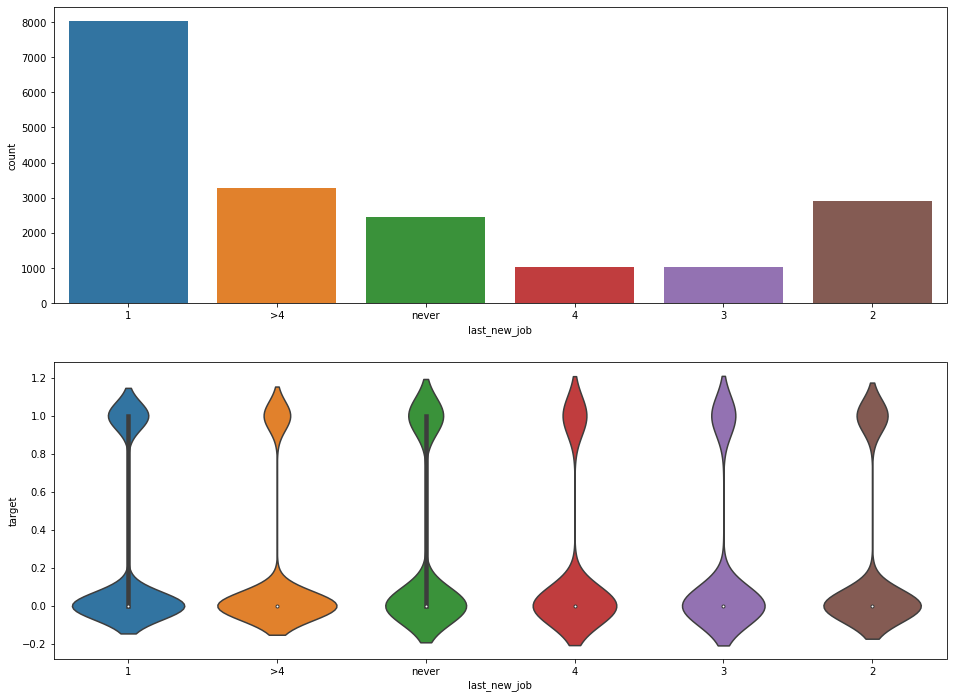

In [23]:
# check the column "last_new_job" 
# not taking 1 year as account, it may seems that candidates with more than 4 years were not likely to look for job change


plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.countplot(data=train, x="last_new_job")

plt.subplot(2,1,2)
sns.violinplot(x='last_new_job', y='target', data=train)

## Missing Values Imputation

In [24]:
# for these columns, I will impute them with their mode

column_list = ["gender", "enrolled_university", "major_discipline", "experience", "company_size", "company_type"]

for col in column_list:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)

In [26]:
# for column "education_level", it seems that "Primary School" and "Phd" are not likely to look for job change.
# for target as "0", I will impute missing values with random selection of either "Primary School" or "Phd"
# as for target as "1", I will impute missing values with "Graduate"

education_list = ["Primary School", "Phd"]

train_index = train[train["education_level"].isnull()].index
test_index = test[test["education_level"].isnull()].index

for idx in train_index:
    if train.loc[idx, "target"] == 0:
        train.loc[idx, "education_level"] = random.choice(education_list)
    else:
        train.loc[idx, "education_level"] = "Graduate"

for idx in test_index:   
    test.loc[idx, "education_level"] = random.choice(education_list)

In [27]:
# for column "last_new_job", it seems that candidates with more than 4 years were not likely to look for job change
# for target "0", I will impute missing values with ">4"
# as for target "1", I will impute missing values with "never"

train_index = train[train["last_new_job"].isnull()].index
test_index = test[test["last_new_job"].isnull()].index

for idx in train_index:
    if train.loc[idx, "target"] == 0:
        train.loc[idx, "last_new_job"] = ">4"
    else:
        train.loc[idx, "last_new_job"] = "never"

for idx in test_index:
    test.loc[idx, "last_new_job"] = ">4" 

In [28]:
# check again to ensure no missing values left

train.isnull().mean()

city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [29]:
test.isnull().mean()

city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
dtype: float64

## Encode

In [30]:
# for column "relevent_experience", candidates with "has relevent experience" carried more weights 
# than ones with "has no relevent experience"
# I will encode "has relevent experience" as 1, "has no relevent experience" as 0

train["relevent_experience"] = train["relevent_experience"].map({"Has relevent experience":1, "No relevent experience":0})
test["relevent_experience"] = test["relevent_experience"].map({"Has relevent experience":1, "No relevent experience":0})

In [31]:
# for column "experience", I will replace ">20" with "21", "<1" with "0"
# then I will change that column from object to int

train["experience"] = train["experience"].replace(">20", "21").replace("<1", "0")
train["experience"] = train["experience"].astype(int)

test["experience"] = test["experience"].replace(">20", "21").replace("<1", "0")
test["experience"] = test["experience"].astype(int)

In [32]:
# for column "company_size", I will replace them with a set of values

train["company_size"] = train["company_size"].map({"<10":0, "10/49":1, "50-99":2, "100-500":3, "500-999":4,
                                                         "1000-4999":5, "5000-9999":6, "10000+":7})
test["company_size"] = test["company_size"].map({"<10":0, "10/49":1, "50-99":2, "100-500":3, "500-999":4,
                                                         "1000-4999":5, "5000-9999":6, "10000+":7})

In [33]:
# for column "last_new_job", I will replace ">4" with "5", "never" with "0"
# then I will change that column from object to int

train["last_new_job"] = train["last_new_job"].replace(">4", "5").replace("never", "0")
train["last_new_job"] = train["last_new_job"].astype(int)

test["last_new_job"] = test["last_new_job"].replace(">4", "5").replace("never", "0")
test["last_new_job"] = test["last_new_job"].astype(int)

## Split train and test into features and target set

In [34]:
x_train = train.drop("target", axis=1)
y_train = train["target"]

## Create dummy variables for object variables

In [36]:
for col in x_train.columns:
    if x_train[col].dtype == "O":
        train_dummies = pd.get_dummies(x_train[col], drop_first=True)
        test_dummies = pd.get_dummies(test[col], drop_first=True)
        
        x_train = pd.concat([x_train, train_dummies], axis=1)
        test = pd.concat([test, test_dummies], axis=1)
        
        x_train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

## Feature Selection

In [37]:
# check for constant features, meaning feature that contains all the same value throught its rows
# empty list meaning there is no constant feature

sel = VarianceThreshold(threshold=0)
sel.fit(x_train)

print([x for x in x_train if x not in x_train.columns[sel.get_support()]])

[]


In [38]:
# check for quasi-constant features, meaning feature that contains almost all the same value throughout its rows
# empty list meaning there is no quasi-constant feature

sel = VarianceThreshold(threshold=0.01)
sel.fit(x_train)

print([x for x in x_train if x not in x_train.columns[sel.get_support()]])

[]


In [39]:
# check for correlation
# empty means there is no correlation between features

corrmat = x_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ["feature1", "feature2", "corr"]
corrmat

Empty DataFrame
Columns: [feature1, feature2, corr]
Index: []

In [40]:
# # check feature importances of variables by using RandomForestClassifier

# tree = RandomForestClassifier(n_estimators=400, random_state=101)
# tree.fit(x_train.values, y_train)

# feat_df = pd.DataFrame(zip(x_train.columns, tree.feature_importances_), columns=["Features", "Feature_Importances"])
# feat_df.sort_values("Feature_Importances", ascending=False, inplace=True)

In [41]:
# # check the first five most important features

# feat_df.head()

In [42]:
# # perform recursive feature addition to find out important features

# features = list(feat_df["Features"].values)

# model_one_feature = RandomForestClassifier(n_estimators=400, random_state=101)
# model_one_feature.fit(x_train[features[0]].to_frame(), y_train)
# y_pred_test = model_one_feature.predict_proba(x_test[features[0]].to_frame())[:,1]
# auc_score_first = roc_auc_score(y_test, y_pred_test)

# tol = 0.001
# features_to_keep = [features[0]]

# for feature in features[1:]:
#     model_int = RandomForestClassifier(n_estimators=400, random_state=100)
#     model_int.fit(x_train[features_to_keep + [feature]], y_train)
#     y_pred_test = model_int.predict_proba(x_test[features_to_keep + [feature]])[:,1]
#     auc_score_int = roc_auc_score(y_test, y_pred_test)
    
#     diff_auc = auc_score_int - auc_score_first
    
#     if diff_auc >= tol:
#         auc_score_first = auc_score_int
#         features_to_keep.append(feature)
#     else:
#         print("Remove", feature)

In [43]:
# remove other unnecessary columns

# x_train = x_train[features_to_keep]
# x_test = x_test[features_to_keep]

## Model Training

In [44]:
lr_model = LogisticRegression()
rf_model = RandomForestClassifier(random_state=101)
ada_model = AdaBoostClassifier(random_state=101)
tree_model = ExtraTreesClassifier(random_state=101)
xgb_model = XGBClassifier(random_state=101)
lgb_model = LGBMClassifier(random_state=101)
gra_model = GradientBoostingClassifier(random_state=101)

In [45]:
score_dict = {}
model_selections = {"LogisticRegression":lr_model, "RandomForestClassifier":rf_model, "AdaBoostClassifier":ada_model,
                   "ExtraTreesClassifier":tree_model, "XGBClassifier":xgb_model, "LGBMClassifier":lgb_model,
                   "GradientBoostingClassifier":gra_model}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

for model_type, model in model_selections.items():
    score = np.mean(cross_val_score(model, x_train, y_train, cv=cv, scoring="accuracy"))
    score_dict[model_type] = score

In [46]:
# seems like GradientBoostingClassifier performs better than the rest

model_score_df = pd.DataFrame(score_dict.items(), columns=["Model", "Score"]).sort_values("Score", ascending=False)
model_score_df.head()

Model     Score
6  GradientBoostingClassifier  0.786756
2          AdaBoostClassifier  0.775412
1      RandomForestClassifier  0.772036
0          LogisticRegression  0.766886
3        ExtraTreesClassifier  0.758691

## Model Hyperparameters Tuning

In [47]:
# find the best n_estimators

model0 = GradientBoostingClassifier(learning_rate=0.2, subsample=0.8, min_samples_split=500, min_samples_leaf=50,
                                         max_depth=8, random_state=101)

param_grid = {"n_estimators":range(10,110,10)}

grid = GridSearchCV(estimator=model0, cv=cv, param_grid=param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 30}
0.7853467115818238


In [48]:
# find the best max_depth and min_samples_split

model1 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, subsample=0.8, min_samples_leaf=50, random_state=101)

param_grid = {"max_depth":range(4,10,1), "min_samples_split":range(400,1000,100)}

grid = GridSearchCV(estimator=model1, cv=cv, param_grid=param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 7, 'min_samples_split': 900}
0.786982144771436


In [49]:
# find the best min_samples_leaf

model2 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, subsample=0.8, max_depth=7, min_samples_split=900,
                                    random_state=101)

param_grid = {"min_samples_leaf":range(30,70,10)}

grid = GridSearchCV(estimator=model2, cv=cv, param_grid=param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'min_samples_leaf': 50}
0.786982144771436


In [50]:
# find the best subsample

model3 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, min_samples_leaf=50, max_depth=9, min_samples_split=800,
                                    random_state=101)

param_grid = {"subsample":[0.6,0.7,0.75,0.8,0.85,0.9]}

grid = GridSearchCV(estimator=model3, cv=cv, param_grid=param_grid)
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'subsample': 0.9}
0.7869647565006148


In [51]:
final_model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, min_samples_leaf=50, max_depth=9, 
                                         min_samples_split=800, subsample=0.9, random_state=101)
final_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, min_samples_leaf=50,
                           min_samples_split=800, n_estimators=30,
                           random_state=101, subsample=0.9)

In [52]:
# find the average cross_val_score

print(np.mean(cross_val_score(final_model, x_train, y_train, cv=cv, scoring="accuracy")))

0.7869647565006148
